Import Part

In [36]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
from scipy import stats
from pandas import DataFrame

Const

In [37]:
FILES_FOLDER_PATH = 'files_cambridgeshire_bedfordshire'
FILE_NAME = 'cambridgeshire_bedfordshire.csv'

Functions

In [38]:
def remove_outliers(df: DataFrame):
    Q1 = np.percentile(df['wqi'], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(df['wqi'], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    ''' Removing the Outliers '''
    df = df[(df['wqi'] > (Q1 - 1.5 * IQR)) & (df['wqi'] < (Q3 + 1.5 * IQR))]
    return df

Loading dataset

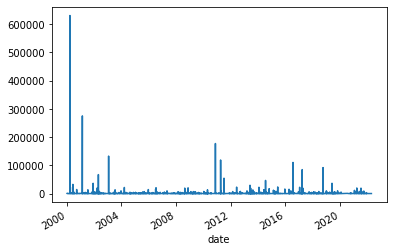

5210  entries


In [41]:
df = pd.read_csv(os.path.join(FILES_FOLDER_PATH, FILE_NAME), header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date', ascending=True)
df['wqi'].plot()
pyplot.show()
total = len(df)
print(total, " entries")

Removing outliers

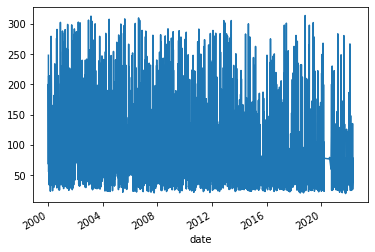

740  out of  5210  entries removed.


In [42]:
df = remove_outliers(df)
df['wqi'].plot()
pyplot.show()
print(total - len(df), " out of ", total, " entries removed.")

Sliding window

In [46]:
STEP = 1 # fixed step for now
values = DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.index = df.index
len(dataframe.columns)
# dataframe.columns = [ f"{col} (t-1)" for col in df.columns ] + [ f"{col} (t-2)" for col in df.columns[:-1]] + ['y']
dataframe.columns = [ f"x{i}" for i in range(1, len(df.columns) * 2)] + ["y"]
dataframe = dataframe.dropna()
dataframe

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x13,x14,x15,x16,x17,x18,x19,x20,x21,y
date,,,,,,,,,,,,,,,,,,,,,
2000-01-06,5.34,0.54,10.40,1.73,540.00,7.95,5.38,10.62,1219.09,1.67,...,0.13,11.20,1.43,596.67,7.97,3.79,11.50,990.82,1.00,68.00
2000-01-07,8.02,0.13,11.20,1.43,596.67,7.97,3.79,11.50,990.82,1.00,...,0.41,8.50,2.00,335.00,8.12,16.97,12.06,1722.86,0.67,200.36
2000-01-11,5.43,0.41,8.50,2.00,335.00,8.12,16.97,12.06,1722.86,0.67,...,0.10,12.03,1.02,245.00,8.08,4.55,11.64,910.70,0.98,55.27
2000-01-12,6.51,0.10,12.03,1.02,245.00,8.08,4.55,11.64,910.70,0.98,...,0.46,11.10,1.02,90.00,8.24,6.06,10.90,1473.75,2.33,213.76
2000-01-13,5.60,0.46,11.10,1.02,90.00,8.24,6.06,10.90,1473.75,2.33,...,0.18,8.50,1.85,230.00,7.98,15.14,10.43,1030.33,1.00,96.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20,11.98,0.07,8.18,2.00,335.00,8.01,2.40,11.60,826.60,0.67,...,0.06,5.15,2.00,335.00,7.46,6.05,10.45,1144.50,0.67,38.08
2022-04-21,12.16,0.06,5.15,2.00,335.00,7.46,6.05,10.45,1144.50,0.67,...,0.28,9.19,2.00,335.00,7.54,6.05,11.01,1122.25,0.67,135.04
2022-04-22,12.28,0.28,9.19,2.00,335.00,7.54,6.05,11.01,1122.25,0.67,...,0.03,4.25,2.00,335.00,8.39,6.05,10.90,1140.00,0.67,26.37


Training model

In [47]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

In [33]:
X = dataframe.values[:, :-1]
y = dataframe.values[:, -1]

train_max_index = int(len(X) * 0.8)
Xtrain = X[: train_max_index]
ytrain = y[: train_max_index]
Xtest = X[train_max_index:]
ytest= y[train_max_index:]

In [35]:

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=False)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(Xtrain):
	# split data
	X_train, X_test = Xtrain[train_ix, :], Xtrain[test_ix, :]
	y_train, y_test = ytrain[train_ix], ytrain[test_ix]
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=3, shuffle=False)
	# define the model
	model = RandomForestRegressor(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [500, 1000]
	space['max_features'] = [10, 12, 15]
	# define search
	search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', cv=cv_inner, refit=True, n_jobs=-1)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = mean_squared_error(y_test, yhat, squared=False)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=57.187, est=-52.055, cfg={'max_features': 15, 'n_estimators': 1000}
>acc=49.956, est=-52.330, cfg={'max_features': 15, 'n_estimators': 1000}
>acc=23.336, est=-53.975, cfg={'max_features': 15, 'n_estimators': 500}
>acc=28.109, est=-50.556, cfg={'max_features': 15, 'n_estimators': 500}
>acc=61.613, est=-46.771, cfg={'max_features': 15, 'n_estimators': 500}
>acc=33.032, est=-51.168, cfg={'max_features': 15, 'n_estimators': 500}


KeyboardInterrupt: 

In [ ]:
model2 = RandomForestRegressor(n_estimators=500, max_features=15)
pred = model2.predict(X)
print(mean_squared_error(y, pred, squared=False))